In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from statsmodels.stats.power import TTestIndPower
from scipy import stats

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_file, export_png, export_svgs
from bokeh.layouts import row, column, gridplot
from bokeh.models import ColumnDataSource, Legend, BoxAnnotation, HoverTool, Plot, FactorRange, TapTool, OpenURL, Range1d, LegendItem
from bokeh.models.widgets import Tabs, Panel

import statsmodels.api as sm

In [2]:
2*((stats.norm.isf(1-0.05/2) + stats.norm.isf(1-0.02))/(5/8))**2

82.48264296892928

In [3]:
1-stats.norm.sf(np.sqrt(85/2)*(5/8)-stats.norm.ppf(1-0.05/2))

0.9827653081016123

In [4]:
TTestIndPower().solve_power(5/8, ratio=1, alpha=0.05, nobs1=None, power=0.98, alternative='two-sided')

83.45627767136234

In [5]:
!wget "https://docs.google.com/spreadsheets/d/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM/export?format=xlsx" -O "../metadata.xlsx"

--2023-07-12 18:12:49--  https://docs.google.com/spreadsheets/d/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM/export?format=xlsx
Resolving docs.google.com (docs.google.com)... 142.250.115.139, 142.250.115.102, 142.250.115.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.115.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-14-5g-sheets.googleusercontent.com/export/61n3kh26mivuiertrk0p4veisk/r3hv4o0mr4q6b2in438ls4o0sk/1689203570000/102025844088317935117/*/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM?format=xlsx [following]
--2023-07-12 18:12:50--  https://doc-14-5g-sheets.googleusercontent.com/export/61n3kh26mivuiertrk0p4veisk/r3hv4o0mr4q6b2in438ls4o0sk/1689203570000/102025844088317935117/*/1O8YItuJ4CtaFFEXbjBcxvhUoM7v9AX1uFDRMhh7iQZM?format=xlsx
Resolving doc-14-5g-sheets.googleusercontent.com (doc-14-5g-sheets.googleusercontent.com)... 142.250.138.132
Connecting to doc-14-5g-sheets.googleusercontent.com (doc-14-5

In [6]:
data = pd.read_excel('../metadata.xlsx', sheet_name='WearableBP Paper Metadata')

# Housekeeping

In [7]:
import nltk
from rake_nltk import Rake
nltk.download('stopwords')

def find_keywords(x, include_columns):
    s = ''
    for col in include_columns:
        if x[col] != x[col]:
            pass
        else:
            s += ' ' + str(x[col])
            
    rake_nltk_var = Rake()
    rake_nltk_var.extract_keywords_from_text(s)
    keywords = rake_nltk_var.get_ranked_phrases()
    return ' '.join(keywords)

include_columns = ['Authors', 'Title', 'Source', 'Exclude Reason', 'Key Devices and Measurements', 'Calibration Technique', 'Algorithm', 'Dataset', 'Training Subject Characteristics', 'Testing Subject Characteristics', 'Study Characteristics','Evaluation Metric', 'Notes', 'Abstract']
data['Keywords'] = data.apply(find_keywords, axis=1, args=(include_columns, ))

[nltk_data] Downloading package stopwords to /Users/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
a = data.copy().dropna(subset='Exclude Reason')
len(a[a['Exclude Reason'].str.contains('record split without personalization')])

330

In [9]:
def compress_authors(x):
    a = x.split(',')[0].split(' ')
    if len(a) == 1:
        return a[0]
    elif len(a) == 2:
        return a[1]
    elif len(a) == 3:
        return a[2]
    else:
        return a[-1]

df = data.copy()
df = df[(df['Include'] == 1) & (df['BP Distribution Type'] == 'ME') & ((df['Evaluation Metric'] == 'MAE') | (df['Evaluation Metric'] == 'ME'))]

df['Sensor Data'] = df['Key Devices and Measurements'].str.split(';', expand=True)[0]
df['Calibration Technique'] = df['Calibration Technique'].str.split(';', expand=True)[0]
df['Algorithm'] = df['Algorithm'].str.split(';', expand=True)[0]
df['Dataset'] = df['Dataset'].str.split(';', expand=True)[0]
df['Testing Subject Characteristics'] = df['Testing Subject Characteristics'].str.split(';', expand=True)[0]
df['Study Characteristics'] = df['Study Characteristics'].str.split(';', expand=True)[0]
df['Algorithm'] = df['Algorithm'].str.split(';', expand=True)[0]
df['SBP Distribution Raw'] = df['BP Distribution'].str.split(';', expand=True)[0]
df['SBP Distribution STD'] = df['SBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
df['DBP Distribution Raw'] = df['BP Distribution'].str.split(';', expand=True)[1]
df['DBP Distribution STD'] = df['DBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
df['SBP Reported Error Raw'] = df['Reported Result'].str.split(';', expand=True)[0]
df['DBP Reported Error Raw'] = df['Reported Result'].str.split(';', expand=True)[1]

In [10]:
df_mae = df[df['Evaluation Metric'] == 'MAE']
df_mae['SBP Error STD'] = df_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
df_mae['DBP Error STD'] = df_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
df_me = df[df['Evaluation Metric'] == 'ME']
df_me['SBP Error STD'] = df_me['SBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
df_me['DBP Error STD'] = df_me['DBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
df_concat = pd.concat([df_me, df_mae], axis=0)
df_concat['SBP ED'] = df_concat['SBP Distribution STD']/df_concat['SBP Error STD']
df_concat['DBP ED'] = df_concat['DBP Distribution STD']/df_concat['DBP Error STD']

df_concat['SBP ED 95CI UB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
df_concat['SBP ED 95CI LB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(1-0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
df_concat['SBP ED MOE'] = (df_concat['SBP ED 95CI UB'] - df_concat['SBP ED 95CI LB'])/2
df_concat['DBP ED 95CI UB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
df_concat['DBP ED 95CI LB'] = df_concat.apply(lambda x: np.sqrt(stats.f.isf(1-0.05/2, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
df_concat['DBP ED MOE'] = (df_concat['DBP ED 95CI UB'] - df_concat['DBP ED 95CI LB'])/2

df_concat['Authors'] = df_concat['Authors'].apply(compress_authors) + ' et al.'
compute_power = lambda x: TTestIndPower().solve_power(5/8, ratio=1, alpha=0.05, nobs1=x, power=None, alternative='two-sided')
df_concat['Power'] = df_concat['Number of Test Subjects'].apply(compute_power)
# 2*((stats.norm.isf(1-0.05/2) + stats.norm.isf(1-0.02))/(5/8))**2
# 1-stats.norm.sf(np.sqrt(85/2)*(5/8)-stats.norm.ppf(1-0.05/2))

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/4128608041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mae['SBP Error STD'] = df_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/4128608041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mae['DBP Error STD'] = df_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/4128608041.py:5: 

In [11]:
len(df_concat[df_concat['Calibration Technique'] == 'personalization'])

11

# Create Subject Split and Personalization Tables

In [12]:
save_cols = ['Title', 'ArticleURL', 'Authors', 'Year', 'Calibration Technique', 'Sensor Data', 'Algorithm', 'Dataset', 'Number of Test Subjects', 'Testing Subject Characteristics', 'Study Characteristics', 'SBP Distribution STD', 'DBP Distribution STD', 'Reported Result', 'SBP ED', 'DBP ED', 'SBP ED MOE', 'DBP ED MOE', 'Power', 'Original Model Implementation Availability', 'Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Availability', 'Exact Dataset/Pre-processing Code Link']

def make_clickable(name, url):
    return '<a href="' + url + '">' + name + '</a>'

save_table = df_concat.copy()[save_cols]
save_table['Title'] = make_clickable(save_table['Title'] + ' (' + save_table['Authors'] + ', '+ save_table['Year'].astype(int).astype(str) + ')', save_table['ArticleURL'])
save_table.drop(['Year'], axis=1, inplace=True)
save_table.drop(['Authors'], axis=1, inplace=True)
save_table.drop(['ArticleURL'], axis=1, inplace=True)

save_table['Original Model Implementation Availability'] = make_clickable(save_table['Original Model Implementation Availability'], save_table['Original Model Implementation Link'])
save_table['Exact Dataset/Pre-processing Code Availability'] = make_clickable(save_table['Exact Dataset/Pre-processing Code Availability'], save_table['Exact Dataset/Pre-processing Code Link'])
save_table.drop(['Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Link'], axis=1, inplace=True)

sls_save_table = save_table[save_table['Calibration Technique'] == 'subject split']
per_save_table = save_table[save_table['Calibration Technique'] == 'personalization']

save_table.to_html('./_includes/include_table.html', index=False, render_links=True, table_id='itable', escape=False)
sls_save_table.to_html('./_includes/include_sls_table.html', index=False, render_links=True, table_id='islstable', escape=False)
per_save_table.to_html('./_includes/include_per_table.html', index=False, render_links=True, table_id='ipertable', escape=False)

In [13]:
p_power = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization'].Power.values, save_table[save_table['Calibration Technique'] == 'subject split'].Power.values, equal_var=False)

p_sbp_ed = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization']['SBP ED'].values, save_table[save_table['Calibration Technique'] == 'subject split']['SBP ED'].values, equal_var=False, nan_policy='omit')
p_dbp_ed = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization']['DBP ED'].values, save_table[save_table['Calibration Technique'] == 'subject split']['DBP ED'].values, equal_var=False, nan_policy='omit')

p_sbp_dist = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization']['SBP Distribution STD'].values, save_table[save_table['Calibration Technique'] == 'subject split']['SBP Distribution STD'].values, equal_var=False, nan_policy='omit'), 
p_dbp_dist = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization']['DBP Distribution STD'].values, save_table[save_table['Calibration Technique'] == 'subject split']['DBP Distribution STD'].values, equal_var=False, nan_policy='omit')

p_num_testing = stats.ttest_ind(save_table[save_table['Calibration Technique'] == 'personalization']['Number of Test Subjects'].values.astype(float), save_table[save_table['Calibration Technique'] == 'subject split']['Number of Test Subjects'].values.astype(float), equal_var=False, nan_policy='omit')

p_power, p_sbp_ed, p_dbp_ed, p_sbp_dist, p_dbp_dist, p_num_testing

(Ttest_indResult(statistic=0.1898815618580575, pvalue=0.8520061810969135),
 Ttest_indResult(statistic=-5.147289314791974, pvalue=4.3122285872659485e-06),
 Ttest_indResult(statistic=-4.0993609652351495, pvalue=0.0001740781381879387),
 (Ttest_indResult(statistic=-2.5995108921064296, pvalue=0.022208263516253875),),
 Ttest_indResult(statistic=-2.9729718500633995, pvalue=0.01024014473722676),
 Ttest_indResult(statistic=-1.9113542028317358, pvalue=0.06054862382437286))

# Create Interactive Metadata Statistics Figure

In [14]:
cat_columns = ['Sensor Data', 'Algorithm', 'Dataset', 'Testing Subject Characteristics', 'Study Characteristics']
cont_columns = ['Number of Test Subjects', 'SBP Distribution STD', 'DBP Distribution STD', 'SBP ED', 'DBP ED', 'Power']

tooltips = [("% of subject split", "@{subject split pct}"), 
            ("% of personalization", "@{personalization pct}")]

ps = []
for c in cat_columns:
    d = pd.DataFrame(save_table[[c, 'Calibration Technique']].value_counts()).reset_index().rename({0: 'Count'}, axis=1).pivot(index=c, columns='Calibration Technique', values='Count').reset_index().fillna(0)
    d['subject split pct'] = d['subject split']/d['subject split'].sum()*100
    d['personalization pct'] = d['personalization']/d['personalization'].sum()*100
    d['total'] = d['subject split']+d['personalization']
    d = d.sort_values(by='total')
    source = ColumnDataSource(d)
    p = Plot(title=None, width=800, height=600, toolbar_location=None)
    p = figure(y_range=FactorRange(factors=d[c].unique()), plot_width=1000, plot_height=400, title='',
                toolbar_location=None, tooltips=tooltips, tools = [])
    p.hbar_stack(['subject split', 'personalization'], y=c, source=source, fill_color=['#beaed4', '#fdc086'])
    p.x_range = Range1d(0, (d['subject split']+d['personalization']).max())
    p.yaxis.axis_label = c
    p.xaxis.axis_label = 'Number of Studies'
    ps.append(p)
    output_file('./_includes/' + c.replace(' ', '_') + '_stats.html')
    show(p)

for c in cont_columns:
    d = save_table[[c, 'Calibration Technique']]
    d1 = d[d['Calibration Technique'] == 'subject split'].dropna()
    d2 = d[d['Calibration Technique'] == 'personalization'].dropna()
    p1 = figure(title='Subject Split', width=500, height=400, min_border=0, tools='', background_fill_color="#fafafa", toolbar_location=None)
    p2 = figure(title='Personalization', width=500, height=400, min_border=0, tools=[], background_fill_color="#fafafa", toolbar_location=None)
    hist1, edge1 = np.histogram(d1[c], bins=10)
    hist2, edge2 = np.histogram(d2[c], bins=10)
    p1.quad(top=hist1, bottom=0, fill_color='#beaed4', line_color="white", left=edge1[:-1], right=edge1[1:])
    p2.quad(top=hist2, bottom=0, fill_color='#fdc086', line_color="white", left=edge2[:-1], right=edge2[1:])
    
    p1.y_range = Range1d(0, hist1.max())
    if 'STD' in c:
        p1.xaxis.axis_label = c + ' (mmHg)'
        p2.xaxis.axis_label = c + ' (mmHg)'
    else:
        p1.xaxis.axis_label = c
        p2.xaxis.axis_label = c
    p1.yaxis.axis_label = 'Number of Studies'
    p2.y_range = Range1d(0, hist2.max())
    p2.yaxis.axis_label = 'Number of Studies'
    p = row(p1, p2)
    ps.append(p)
    output_file('./_includes/' + c.replace(' ', '_') + '_stats.html')
    show(p)
    

# tabs = []
# for i in range(len(cat_columns)):
#     tabs.append(Panel(child=ps[i], title=cat_columns[i]))
# for i in range(len(cont_columns)):
#     tabs.append(Panel(child=ps[len(cat_columns)+i], title=cont_columns[i]))
# figure_tabs = Tabs(tabs=tabs)
# output_file('./_includes/metadata_stats.html')
# show(figure_tabs)

# Create Metadata Statistics for Paper Figure

In [15]:
cat_columns = ['Sensor Data', 'Algorithm', 'Dataset', 'Study Characteristics']
fig_sizes = {'Sensor Data':(1000, 800), 
             'Algorithm':(1000, 360), 
             'Dataset': (1000, 800), 
             'Study Characteristics': (1000, 360)}

tooltips = [("% of subject split", "@{subject split pct}"), 
            ("% of personalization", "@{personalization pct}")]

font_size = '30px'
ps = []
for c in cat_columns:
    d = pd.DataFrame(save_table[[c, 'Calibration Technique']].value_counts()).reset_index().rename({0: 'Count'}, axis=1).pivot(index=c, columns='Calibration Technique', values='Count').reset_index().fillna(0)
    d['subject split pct'] = d['subject split']/d['subject split'].sum()*100
    d['personalization pct'] = d['personalization']/d['personalization'].sum()*100
    d['total'] = d['subject split']+d['personalization']
    d = d.sort_values(by='total')
    if 'Study' in c:
        d[c] = d[c].str.split(' ', expand=True)[0]
    source = ColumnDataSource(d)
    p = Plot(title=None, width=fig_sizes[c][0], height=fig_sizes[c][1], toolbar_location=None)
    p = figure(y_range=FactorRange(factors=d[c].unique()), plot_width=fig_sizes[c][0], plot_height=fig_sizes[c][1], title='',
                toolbar_location=None, tooltips=tooltips, tools = [])
    p.hbar_stack(['subject split', 'personalization'], y=c, source=source, fill_color=['#beaed4', '#fdc086'], legend_label = ['subject split', 'personalization'])
    p.x_range = Range1d(0, (d['subject split']+d['personalization']).max())
    p.xaxis.axis_label = 'Number of Studies'
    p.yaxis.axis_label = c
    p.yaxis.axis_label_text_font_size = font_size
    p.xaxis.axis_label_text_font_size = font_size
    p.yaxis.major_label_text_font_size = font_size
    p.xaxis.major_label_text_font_size = font_size
    p.title.text_font_size = font_size
    if 'Dataset' in c:
        p.add_layout(p.legend[0], 'above')
        p.legend.location = (-150,25)
        p.legend.label_text_font_size = font_size
    else:
        p.legend.visible = False
    ps.append(p)
    
for c in cont_columns:
    d = save_table[[c, 'Calibration Technique']]
    d1 = d[d['Calibration Technique'] == 'subject split'].dropna()
    d2 = d[d['Calibration Technique'] == 'personalization'].dropna()
    hist1, edge1 = np.histogram(d1[c], bins=10)
    hist2, edge2 = np.histogram(d2[c], bins=10)
    if 'Number of ' in c:
        p1 = figure(title='', width=500, height=350, min_border=0, tools='', background_fill_color="#fafafa", toolbar_location=None, x_axis_type='log')
        hist1, edge1 = np.histogram(np.log10(d1[c].astype(float)), bins=10)
        edge1 = np.power(10, edge1)
    else:
        p1 = figure(title='', width=500, height=350, min_border=0, tools='', background_fill_color="#fafafa", toolbar_location=None)
    p2 = figure(title='', width=500, height=350, min_border=0, tools=[], background_fill_color="#fafafa", toolbar_location=None)
    p1.quad(top=hist1, bottom=0, fill_color='#beaed4', line_color="white", left=edge1[:-1], right=edge1[1:])
    p2.quad(top=hist2, bottom=0, fill_color='#fdc086', line_color="white", left=edge2[:-1], right=edge2[1:])
    
    p1.y_range = Range1d(0, hist1.max())
    if 'STD' in c:
        p1.xaxis.axis_label = c + ' (mmHg)'
        p2.xaxis.axis_label = c + ' (mmHg)'
    else:
        p1.xaxis.axis_label = c
        p2.xaxis.axis_label = c
    if ('Number of Test' in c) or ('SBP Distribution' in c) or ('SBP ED' in c):
        p1.yaxis.axis_label = 'Number of Studies'
    else:
        p1.yaxis.axis_label = ''
    p2.y_range = Range1d(0, hist2.max())
    p1.yaxis.axis_label_text_font_size = font_size
    p1.xaxis.axis_label_text_font_size = font_size
    p1.yaxis.major_label_text_font_size = font_size
    p1.xaxis.major_label_text_font_size = font_size
    p1.title.text_font_size = font_size
    p2.yaxis.axis_label_text_font_size = font_size
    p2.xaxis.axis_label_text_font_size = font_size
    p2.yaxis.major_label_text_font_size = font_size
    p2.xaxis.major_label_text_font_size = font_size
    p2.title.text_font_size = font_size
    p = row(p1, p2)
    ps.append(p)

In [16]:
output_file('./_includes/metadata_stats_paperfig.html')
grid = gridplot([[ps[0], ps[2]], [ps[1], ps[3]], [ps[4], ps[9]], 
                 [ps[5], ps[6]], [ps[7], ps[8]]])
grid.spacing = 1

In [17]:
export_svgs(grid, filename='./_includes/metadata_stats_paperfig.svg')

[]

# Create ED Scatter Plots and generate includes, excludes, and meet specs tables

In [18]:
meetspecs_sls = sls_save_table[(sls_save_table['SBP ED'] > 2.17) & (sls_save_table['DBP ED'] > 1.39)]
meetspecs_sls['SBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
meetspecs_sls['DBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['DBP ED'], axis=1)
meetspecs_cols = ['Title', 'Sensor Data', 'Algorithm', 'Dataset', 'SBP ED', 'DBP ED', 'SBP Distribution STD', 'DBP Distribution STD']

meetspecs_sls = meetspecs_sls[(meetspecs_sls['SBP ED 95CI LB'] > 2.17) & (meetspecs_sls['DBP ED 95CI LB'] > 1.39)].sort_values(by=['SBP ED 95CI LB','DBP ED 95CI LB'], ascending=False)

for col in meetspecs_sls.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
    meetspecs_sls[col] = np.round(meetspecs_sls[col], 2)
    

meetspecs_sls[meetspecs_cols].to_html('./_includes/meetspecs_sls_table.html', index=False, render_links=True, table_id='mslstable', escape=False)

# per_save_table[(per_save_table['SBP ED'] - per_save_table['SBP ED MOE'] > 2.17) & (per_save_table['DBP ED'] - per_save_table['DBP ED MOE'] > 1.39)]

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/3394337663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meetspecs_sls['SBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f.isf(1-0.1, x['Number of Test Subjects']-1, x['Number of Test Subjects']-1))*x['SBP ED'], axis=1)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/3394337663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meetspecs_sls['DBP ED 95CI LB'] = meetspecs_sls.apply(lambda x: np.sqrt(stats.f

In [19]:
meetspecs_sls

,Title,Calibration Technique,Sensor Data,Algorithm,Dataset,Number of Test Subjects,Testing Subject Characteristics,Study Characteristics,SBP Distribution STD,DBP Distribution STD,Reported Result,SBP ED,DBP ED,SBP ED MOE,DBP ED MOE,Power,Original Model Implementation Availability,Exact Dataset/Pre-processing Code Availability,SBP ED 95CI LB,DBP ED 95CI LB
1140,"<a href=""https://www.nature.com/articles/s4159...",subject split,ECG+PPG,deep learning,MIMIC,10,diseased,observational study,12.21,7.45,0.0±1.6; 0.2±1.3,7.63,5.73,5.75,4.32,0.26,NaN,NaN,4.89,3.67
1617,"<a href=""https://ieeexplore.ieee.org/abstract/...",subject split,PPG,deep learning,MIMIC,241,diseased,observational study,30.15,18.84,0.02±5.93; 0.01±3.87,5.08,4.87,0.65,0.62,1.00,"<a href=""https://github.com/Ma-Chenbin/Pseudo-...",NaN,4.68,4.48
1639,"<a href=""https://www.sciencedirect.com/science...",subject split,ECG+PPG,deep learning,MIMIC,3000,diseased,observational study,18.70,9.20,3.52; 2.13,4.24,3.45,0.15,0.12,1.00,"<a href=""https://github.com/marshb/MLP-BP"">Ava...",NaN,4.14,3.37
1625,"<a href=""https://ieeexplore.ieee.org/abstract/...",subject split,PPG,deep learning,Internal,241,diseased,observational study,26.40,17.91,0.013±6.237; 0.011±4.453,4.23,4.02,0.54,0.51,1.00,"<a href=""https://github.com/Ma-Chenbin/Pseudo-...",NaN,3.90,3.70
2062,"<a href=""https://www.osapublishing.org/abstrac...",subject split,PPG,classical ML,Internal,179.2,unclear,observational study,24.00,10.00,4.69; 1.53,4.08,5.21,0.60,0.77,1.00,NaN,NaN,3.71,4.74
734,"<a href=""http://dx.doi.org/10.1109/CISP-BMEI48...",subject split,BCG+PPG,classical ML,Internal,15,healthy,observational study,17.30,9.80,3.08±4.29; 1.52±2.20,4.03,4.45,2.31,2.55,0.38,NaN,NaN,2.84,3.13
1640,"<a href=""https://www.sciencedirect.com/science...",subject split,ECG+PPG,deep learning,MIMIC+UoQ,32,diseased,observational study,18.70,9.20,4.39; 2.54,3.40,2.89,1.24,1.06,0.69,"<a href=""https://github.com/marshb/MLP-BP"">Ava...",NaN,2.69,2.29
1066,"<a href=""https://ieeexplore.ieee.org/document/...",subject split,PPG,classical ML,MIMIC,942,diseased,observational study,25.64,9.31,0.09±10.38; 0.23±4.22,2.47,2.21,0.16,0.14,1.00,"<a href=""https://github.com/navidhasanzadeh/BP...","<a href=""https://github.com/navidhasanzadeh/BP...",2.37,2.12
1976,"<a href=""http://ojs.midem-drustvo.si/index.php...",subject split,ultrasound,physiological model,Internal,211,healthy,observational study,11.28,10.91,-0.233±4.538; 0.118±4.218,2.49,2.59,0.34,0.35,1.00,NaN,NaN,2.27,2.37


In [20]:
# get exclude table
exclude_table = data[data['Include'] == 0]
exclude_table['Year'] = exclude_table['Year'].fillna(0)
exclude_table['Authors'] = exclude_table['Authors'].fillna('Not Available')
exclude_table['Title'] = make_clickable(exclude_table['Title'] + ' ' + exclude_table['Year'].astype(int).astype(str), exclude_table['ArticleURL'])
exclude_table['Authors'] = exclude_table['Authors'].apply(compress_authors) + ' et al.'
exclude_table = exclude_table[['Title', 'Authors', 'Exclude Reason']]
exclude_table.to_html('./_includes/exclude_table.html', index=False, render_links=True, table_id='etable', escape=False)

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/2903807737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_table['Year'] = exclude_table['Year'].fillna(0)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/2903807737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_table['Authors'] = exclude_table['Authors'].fillna('Not Available')
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/2903807737.py:5: SettingWithCopyWarning: 
A value is trying

In [21]:
hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 20px"> @{Hover Title} </span> <br>
                <span style="font-size: 10px"> @{Title} </span> <br>
                <span style="font-size: 10px"> Sensor Data: @{Sensor Data}</span> <br>
                <span style="font-size: 10px"> SBP/DBP Reported Result (mmHg): @{SBP Reported Error Raw} /  @{DBP Reported Error Raw} </span> <br>
                <span style="font-size: 10px"> SBP Explained Deviation ± Margin of Error: @{SBP ED} ± @{SBP ED MOE}</span> <br>
                <span style="font-size: 10px"> DBP Explained Deviation ± Margin of Error: @{DBP ED} ± @{DBP ED MOE}</span> <br>
                <span style="font-size: 10px"> SBP Distribution STD: @{SBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> DBP Distribution STD: @{DBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> Power: @{Power}</span> <br>
                <span style="font-size: 10px"> Number of Test Subjects: @{Number of Test Subjects}</span> <br>
                <span style="font-size: 10px"> Study Characteristics: @{Study Characteristics}</span>
            </div>
        </div>
        """
    )
cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']

In [22]:
plot_df_sls = sls_save_table[sls_save_table['Calibration Technique'] == 'subject split'].dropna(subset=['SBP ED', 'DBP ED'], axis=0)
Y = plot_df_sls['SBP ED']
X = plot_df_sls['DBP ED']
plot_df_sls_x = np.linspace(X.min(), X.max(), 100)
plot_df_sls_x = sm.add_constant(plot_df_sls_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
sls_params = results.params.values
sls_pval = results.pvalues[1]
sls_y = results.predict(plot_df_sls_x)
sls_x = plot_df_sls_x[:, 1]
sls_ci = results.conf_int().values[1, :]

plot_df_per = per_save_table[per_save_table['Calibration Technique'] == 'personalization'].dropna(subset=['SBP ED', 'DBP ED'], axis=0)
Y = plot_df_per['SBP ED']
X = plot_df_per['DBP ED']
plot_df_per_x = np.linspace(X.min(), X.max(), 100)
plot_df_per_x = sm.add_constant(plot_df_per_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
per_params = results.params.values
per_pval = results.pvalues[1]
per_y = results.predict(plot_df_per_x)
per_x = plot_df_per_x[:, 1]
per_ci = results.conf_int().values[1, :]

# overall
plot_df = save_table.dropna(subset=['SBP ED', 'DBP ED'], axis=0)
Y = plot_df['SBP ED']
X = plot_df['DBP ED']
plot_df_x = np.linspace(X.min(), X.max(), 100)
plot_df_x = sm.add_constant(plot_df_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
params = results.params.values
pval = results.pvalues[1]
y = results.predict(plot_df_x)
x = plot_df_x[:, 1]
ci = results.conf_int().values[1, :]

In [ ]:
output_file('./_includes/scatter.html')

p51 = figure(title='', background_fill_color="#fafafa", width=800, height=600, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p51.xaxis.axis_label = 'DBP Explained Deviation'
p51.yaxis.axis_label = 'SBP Explained Deviation'
# p2 = figure(title='Personalization', background_fill_color="#fafafa", width=725, height=500, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
# p2.xaxis.axis_label = 'DBP Explained Deviation'
# p2.yaxis.axis_label = 'SBP Explained Deviation'

box = BoxAnnotation(bottom=2.17, left=1.39, fill_alpha=0.05, fill_color='green', line_width=5, line_dash = 'dashed', line_color='green', line_alpha=0.05)
p51.add_layout(box)
# p2.add_layout(box)

plot_df = df_concat.copy()

colors = {}
u_sd = plot_df['Sensor Data'].unique()
for i in range(len(u_sd)):
    colors[u_sd[i]] = cs[i]
plot_df['Color'] = [colors[i] for i in plot_df['Sensor Data']]
plot_df['Size'] = 10/np.sqrt(plot_df['DBP ED MOE']+plot_df['SBP ED MOE'])
plot_df['Hover Title'] = plot_df['Authors'] + ' (' + plot_df['Year'].astype(int).astype(str) + ')'

legend_it = []
for i in range(len(u_sd)):
    d1 = plot_df[plot_df['Sensor Data'] == u_sd[i]]
    sls = d1[d1['Calibration Technique'] == 'subject split']
    per = d1[d1['Calibration Technique'] == 'personalization']
    c1 = p51.scatter(x='DBP ED', y='SBP ED', size='Size', source=ColumnDataSource(sls), fill_alpha=0.4, color='Color', muted_alpha=0, name='subject split', marker='triangle')
    c2 = p51.scatter('DBP ED', 'SBP ED', size='Size', source=ColumnDataSource(per), fill_alpha=0.4, color='Color', muted_alpha=0, name='personalization', marker='plus')
    c3 = p51.scatter('DBP ED', 'SBP ED', size='Size', source=ColumnDataSource(sls), fill_alpha=0.4, color='Color', muted_alpha=0, visible = False, marker='triangle')
    taptool1 = p51.select(type=TapTool)
    taptool1.callback = OpenURL(url='@ArticleURL')
    # taptool2 = p2.select(type=TapTool)
    # taptool2.callback = OpenURL(url='@ArticleURL')
    legend_it.append((u_sd[i], [c1, c2, c3]))
    legend = Legend(items=legend_it)
    legend.click_policy='mute'
    legend.location = 'top_left'

c100 = p51.line(x, y, line_width=3, legend_label='Slope=' + "{:.3f}".format(params[1]) + ' (CI = [' + "{:.3f}".format(ci[0]) + ', ' + "{:.3f}".format(ci[1]) + '], ' + 'p=' + "{:.1e}".format(pval) + '*)')
# c101 = p2.line(per_x, per_y, line_width=3, legend_label='Slope=' + "{:.3f}".format(per_params[1]) + ' (CI = [' + "{:.3f}".format(per_ci[0]) + ', ' + "{:.3f}".format(per_ci[1]) + '], ' + 'p=' + "{:.1e}".format(per_pval) + ')')
    
# p2.add_layout(legend, 'right')
p51.add_layout(legend, 'right')

MARKERS = ['triangle', 'plus']
labels = ['subject split', 'personalization']
rs = p51.scatter(x=0, y=0, color="grey", marker=MARKERS)
rs.visible = False
legend2 = Legend(items=[LegendItem(label=labels[i], renderers=[rs], index=i) for i, s in enumerate(MARKERS)
], location="bottom_right")
p51.add_layout(legend2)

show(p51)

export_svgs(grid, filename='./_includes/scatter.svg')

[]

# Create Code Availability Table

In [ ]:
save_cols = ['Title', 'Authors', 'ArticleURL', 'Year', 'Sensor Data', 'Number of Test Subjects', 'Dataset', 'Calibration Technique', 'SBP ED', 'DBP ED', 'Original Model Implementation Availability', 'Original Model Implementation Link', 'Exact Dataset/Pre-processing Code Availability', 'Exact Dataset/Pre-processing Code Link', 'wearablebp.github.io Implementation Result']
availability_table = df_concat.copy()[save_cols]
availability_table['Title'] = make_clickable(availability_table['Title'] + ' (' + availability_table['Authors'] + ', ' + availability_table['Year'].astype(int).astype(str) + ')', availability_table['ArticleURL'])
# availability_table.drop('ArticleURL', axis=1, inplace=True)

availability_table['Original Model Implementation Availability'] = make_clickable(availability_table['Original Model Implementation Availability'], availability_table['Original Model Implementation Link'])
availability_table['Exact Dataset/Pre-processing Code Availability'] = make_clickable(availability_table['Exact Dataset/Pre-processing Code Availability'], availability_table['Exact Dataset/Pre-processing Code Link'])

availability_table[['Title', 'Sensor Data', 'Dataset', 'Calibration Technique', 'SBP ED', 'DBP ED', 'Original Model Implementation Availability', 'Exact Dataset/Pre-processing Code Availability', ]].rename({'SBP ED':'Reported SBP ED', 'DBP ED': 'Reported DBP ED'}, axis=1).to_html('./_includes/availability_table.html', index=False, render_links=True, table_id='atable', escape=False)

# Other paper plots

## Error vs STD

In [ ]:
# remove outlier based on influence z > 4
plot_df = plot_df.drop([806])

In [ ]:
Y = plot_df['SBP Error STD']
X = plot_df['SBP Distribution STD']
sbp_x = np.linspace(X.min(), X.max(), 100)
sbp_x = sm.add_constant(sbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
sbp_params = results.params.values
sbp_pval = results.pvalues[1]
sbp_y = results.predict(sbp_x)
sbp_x = sbp_x[:, 1]
sbp_ci = results.conf_int().values[1, :]

In [ ]:
XY = plot_df[['DBP Error STD', 'DBP Distribution STD']].dropna()
Y = XY['DBP Error STD']
X = XY['DBP Distribution STD']
dbp_x = np.linspace(X.min(), X.max(), 100)
dbp_x = sm.add_constant(dbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
dbp_params = results.params.values
dbp_pval = results.pvalues[1]
dbp_y = results.predict(dbp_x)
dbp_x = dbp_x[:, 1]
dbp_ci = results.conf_int().values[1, :]

In [ ]:
sbp_ci, dbp_ci, sbp_pval, dbp_pval

(array([0.17967958, 0.50814122]),
 array([0.04843184, 0.52083914]),
 8.646556898654812e-05,
 0.018951174246888986)

In [ ]:
# from statsmodels.stats.outliers_influence import OLSInfluence
# infl = OLSInfluence(results).influence
# infl[stats.zscore(infl) > 4]

In [ ]:
Y = plot_df[plot_df['Calibration Technique'] == 'subject split']['SBP Error STD']
X = plot_df[plot_df['Calibration Technique'] == 'subject split']['SBP Distribution STD']
sls_sbp_x = np.linspace(X.min(), X.max(), 100)
sls_sbp_x = sm.add_constant(sls_sbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
sls_sbp_params = results.params.values
sls_sbp_pval = results.pvalues[1]
sls_sbp_y = results.predict(sls_sbp_x)
sls_sbp_x = sls_sbp_x[:, 1]
sls_sbp_ci = results.conf_int().values[1, :]

dbp_plot_df = plot_df.dropna(subset=['DBP Distribution STD', 'DBP Error STD'], axis=0)
Y = dbp_plot_df[dbp_plot_df['Calibration Technique'] == 'subject split']['DBP Error STD']
X = dbp_plot_df[dbp_plot_df['Calibration Technique'] == 'subject split']['DBP Distribution STD']
sls_dbp_x = np.linspace(X.min(), X.max(), 100)
sls_dbp_x = sm.add_constant(sls_dbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
sls_dbp_params = results.params.values
sls_dbp_pval = results.pvalues[1]
sls_dbp_y = results.predict(sls_dbp_x)
sls_dbp_x = sls_dbp_x[:, 1]
sls_dbp_ci = results.conf_int().values[1, :]

Y = plot_df[plot_df['Calibration Technique'] == 'personalization']['SBP Error STD']
X = plot_df[plot_df['Calibration Technique'] == 'personalization']['SBP Distribution STD']
per_sbp_x = np.linspace(X.min(), X.max(), 100)
per_sbp_x = sm.add_constant(per_sbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
per_sbp_params = results.params.values
per_sbp_pval = results.pvalues[1]
per_sbp_y = results.predict(per_sbp_x)
per_sbp_x = per_sbp_x[:, 1]
per_sbp_ci = results.conf_int().values[1, :]

dbp_plot_df = plot_df.dropna(subset=['DBP Distribution STD', 'DBP Error STD'], axis=0)
Y = dbp_plot_df[dbp_plot_df['Calibration Technique'] == 'personalization']['DBP Error STD']
X = dbp_plot_df[dbp_plot_df['Calibration Technique'] == 'personalization']['DBP Distribution STD']
per_dbp_x = np.linspace(X.min(), X.max(), 100)
per_dbp_x = sm.add_constant(per_dbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
per_dbp_params = results.params.values
per_dbp_pval = results.pvalues[1]
per_dbp_y = results.predict(per_dbp_x)
per_dbp_x = per_dbp_x[:, 1]
per_dbp_ci = results.conf_int().values[1, :]

In [ ]:
sls_sbp_ci, sls_dbp_ci, per_sbp_ci, per_dbp_ci

(array([0.12434603, 0.51364521]),
 array([-0.01369147,  0.54681781]),
 array([0.49722951, 0.87213572]),
 array([0.14996848, 1.05186997]))

In [ ]:
hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 20px"> @{Hover Title} </span> <br>
                <span style="font-size: 10px"> @{Title} </span> <br>
                <span style="font-size: 10px"> Sensor Data: @{Sensor Data}</span> <br>
                <span style="font-size: 10px"> SBP/DBP Reported Result (mmHg): @{SBP Reported Error Raw} /  @{DBP Reported Error Raw} </span> <br>
                <span style="font-size: 10px"> SBP Explained Deviation: @{SBP ED}</span> <br>
                <span style="font-size: 10px"> DBP Explained Deviation: @{DBP ED}</span> <br>
                <span style="font-size: 10px"> SBP Distribution STD: @{SBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> DBP Distribution STD: @{DBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> Power: @{Power}</span> <br>
                <span style="font-size: 10px"> Number of Test Subjects: @{Number of Test Subjects}</span> <br>
                <span style="font-size: 10px"> Study Characteristics: @{Study Characteristics}</span>
            </div>
        </div>
        """
    )
cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']

p203 = figure(title='', background_fill_color="#fafafa", width=500, height=600, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p203.xaxis.axis_label = 'SBP Distribution STD (mmHg)'
p203.yaxis.axis_label = 'SBP Error STD (mmHg)'
p205 = figure(title='', background_fill_color="#fafafa", width=725, height=600, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p205.xaxis.axis_label = 'DBP Distribution STD (mmHg)'
p205.yaxis.axis_label = 'DBP Error STD (mmHg)'

plot_df = df_concat.copy()
plot_df.drop([806], inplace=True)

colors = {}
u_sd = plot_df['Sensor Data'].unique()
for i in range(len(u_sd)):
    colors[u_sd[i]] = cs[i]
plot_df['Color'] = [colors[i] for i in plot_df['Sensor Data']]
plot_df['Size'] = plot_df['Power']*15
plot_df['Hover Title'] = plot_df['Authors'] + ' (' + plot_df['Year'].astype(int).astype(str) + ')'

legend_it201 = []
for i in range(len(u_sd)):
    d1 = plot_df[plot_df['Sensor Data'] == u_sd[i]]
    d1 = d1.dropna(subset=['Sensor Data'])
    if len(d1) > 0:
        c204 = p203.scatter('SBP Distribution STD', 'SBP Error STD', source=ColumnDataSource(d1), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
        taptool1 = p203.select(type=TapTool)
        taptool1.callback = OpenURL(url='@ArticleURL')

        c207 = p205.scatter('DBP Distribution STD', 'DBP Error STD', source=ColumnDataSource(d1), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
        taptool3 = p205.select(type=TapTool)
        taptool3.callback = OpenURL(url='@ArticleURL')
        legend_it201.append((u_sd[i], [c204, c207]))
        legend201 = Legend(items=legend_it201)
        legend201.click_policy='mute'
    
c10 = p203.line(sbp_x, sbp_y, line_width=3, legend_label='Slope=' + "{:.3f}".format(sbp_params[1]) + '(CI = [' + "{:.3f}".format(sbp_ci[0]) + ', ' + "{:.3f}".format(sbp_ci[1]) + '], ' +'p=' + "{:.1e}".format(sbp_pval) + '*)')
c12 = p205.line(dbp_x, dbp_y, line_width=3, legend_label='Slope=' + "{:.3f}".format(dbp_params[1]) + ' (CI = [' + "{:.3f}".format(dbp_ci[0]) + ', ' + "{:.3f}".format(dbp_ci[1]) + '], ' + 'p=' + "{:.1e}".format(dbp_pval) + '*)')
p205.add_layout(legend201, 'right')

output_file('./_includes/scatter_std_err.html')
show(row([p203, p205]))

export_svgs(row([p203, p205]), filename='./_includes/scatter_std_err.svg')

[]

## Time vs Accuracy Scatter Plot

In [ ]:
def convert_dt(x):
    # if 's' in x:
    #     if x.split('s')[0] == '0':
    #         return 0
    #     return np.log10(int(x.split('s')[0]))+0
    # elif 'm' in x:
    #     return np.log10(int(x.split('m')[0]))+1
    # elif 'h' in x:
    #     return np.log10(int(x.split('h')[0]))+2
    # elif 'd' in x:
    #     return np.log10(int(x.split('d')[0]))+3
    # elif 'mon' in x:
    #     return np.log10(int(x.split('mon')[0]))+4
    if 's' in x:
        if x.split('s')[0] == '0':
            return 0
        return np.log10(int(x.split('s')[0]))
    elif 'm' in x:
        return np.log10(int(x.split('m')[0])*60)
    elif 'h' in x:
        return np.log10(int(x.split('h')[0])*60*60)
    elif 'd' in x:
        return np.log10(int(x.split('d')[0])*60*60*24)
    elif 'mon' in x:
        return np.log10(int(x.split('mon')[0])*60*60*24*30)

per = data[(data['Include'] == 1) & (data['Study Characteristics'].str.contains('observational')) & (data['Time between Calibration and Test'].str.contains('unclear') == False) & (data['Time between Calibration and Test'].str.contains('heart beats') == False) & ((data['Evaluation Metric'] == 'MAE') | (data['Evaluation Metric'] == 'ME'))]

per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
per = per[per['Calibration Technique'] == 'personalization']
per['log_dt'] = per['Time between Calibration and Test'].apply(convert_dt)

per['Sensor Data'] = per['Key Devices and Measurements'].str.split(';', expand=True)[0]
per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
per['Algorithm'] = per['Algorithm'].str.split(';', expand=True)[0]
per['Dataset'] = per['Dataset'].str.split(';', expand=True)[0]
per['Testing Subject Characteristics'] = per['Testing Subject Characteristics'].str.split(';', expand=True)[0]
per['Study Characteristics'] = per['Study Characteristics'].str.split(';', expand=True)[0]
per['Algorithm'] = per['Algorithm'].str.split(';', expand=True)[0]
per['SBP Distribution Raw'] = per['BP Distribution'].str.split(';', expand=True)[0]
per['SBP Distribution STD'] = per['SBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
per['DBP Distribution Raw'] = per['BP Distribution'].str.split(';', expand=True)[1]
per['DBP Distribution STD'] = per['DBP Distribution Raw'].str.split('±', expand=True)[1].astype(float)
per['SBP Reported Error Raw'] = per['Reported Result'].str.split(';', expand=True)[0]
per['DBP Reported Error Raw'] = per['Reported Result'].str.split(';', expand=True)[1]

per_mae = per[per['Evaluation Metric'] == 'MAE']
per_mae['SBP Error STD'] = per_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
per_mae['DBP Error STD'] = per_mae['DBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
per_me = per[per['Evaluation Metric'] == 'ME']
per_me['SBP Error STD'] = per_me['SBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
per_me['DBP Error STD'] = per_me['DBP Reported Error Raw'].str.split('±', expand=True)[1].astype(float)
per_concat = pd.concat([per_me, per_mae], axis=0)
per_concat['SBP ED'] = per_concat['SBP Distribution STD']/per_concat['SBP Error STD']
per_concat['DBP ED'] = per_concat['DBP Distribution STD']/per_concat['DBP Error STD']

per_concat['Number of Test Subjects'] = per_concat['Number of Test Subjects'].replace({'unclear': np.NaN})
per_concat = per_concat.dropna(subset=['Number of Test Subjects'])
per_concat['Power'] = per_concat['Number of Test Subjects'].astype(float).apply(compute_power)

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/189921704.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per['Calibration Technique'] = per['Calibration Technique'].str.split(';', expand=True)[0]
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/189921704.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mae['SBP Error STD'] = per_mae['SBP Reported Error Raw'].astype(float)*np.sqrt(pi/2)
/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/189921704.p

In [ ]:
per_concat_sbp = per_concat.dropna(subset=['SBP Error STD', 'log_dt'], axis=0)
per_concat_sbp = per_concat_sbp[per_concat_sbp['log_dt'] >= 0]
Y = per_concat_sbp['SBP Error STD']
X = per_concat_sbp['log_dt']
per_sbp_x = np.linspace(X.min(), X.max(), 100)
per_sbp_x = sm.add_constant(per_sbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
per_sbp_params = results.params.values
per_sbp_pval = results.pvalues[1]
per_sbp_y = results.predict(per_sbp_x)
per_sbp_x = per_sbp_x[:, 1]
per_sbp_ci = results.conf_int().values[1, :]

per_concat_dbp = per_concat.dropna(subset=['DBP Error STD', 'log_dt'], axis=0)
per_concat_dbp = per_concat_dbp[per_concat_dbp['log_dt'] >= 0]
Y = per_concat_dbp['DBP Error STD']
X = per_concat_dbp['log_dt']
per_dbp_x = np.linspace(X.min(), X.max(), 100)
per_dbp_x = sm.add_constant(per_dbp_x)
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
per_dbp_params = results.params.values
per_dbp_pval = results.pvalues[1]
per_dbp_y = results.predict(per_dbp_x)
per_dbp_x = per_dbp_x[:, 1]
per_dbp_ci = results.conf_int().values[1, :]

In [ ]:
per_sbp_ci, per_dbp_ci

(array([0.43392871, 1.0920085 ]), array([0.37504581, 0.79198235]))

In [36]:
output_file('./_includes/scatter_time.html')

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 20px"> @{Hover Title} </span> <br>
                <span style="font-size: 10px"> @{Title} </span> <br>
                <span style="font-size: 10px"> Sensor Data: @{Sensor Data}</span> <br>
                <span style="font-size: 10px"> SBP/DBP Reported Result (mmHg): @{SBP Reported Error Raw} /  @{DBP Reported Error Raw} </span> <br>
                <span style="font-size: 10px"> SBP Explained Deviation: @{SBP ED}</span> <br>
                <span style="font-size: 10px"> DBP Explained Deviation: @{DBP ED}</span> <br>
                <span style="font-size: 10px"> SBP Distribution STD: @{SBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> DBP Distribution STD: @{DBP Distribution STD} mmHg </span> <br>
                <span style="font-size: 10px"> Power: @{Power}</span> <br>
                <span style="font-size: 10px"> Number of Test Subjects: @{Number of Test Subjects}</span> <br>
                <span style="font-size: 10px"> Study Characteristics: @{Study Characteristics}</span>
            </div>
        </div>
        """
    )
cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']

p10 = figure(title='', background_fill_color="#fafafa", width=500, height=500, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p10.xaxis.axis_label = 'Time between calibration and test (log(seconds))'
p10.yaxis.axis_label = 'SBP Error STD (mmHg)'

p11 = figure(title='', background_fill_color="#fafafa", width=745, height=500, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p11.xaxis.axis_label = 'Time between calibration and test (log(seconds))'
p11.yaxis.axis_label = 'DBP Error STD (mmHg)'

plot_df = per_concat.copy()

colors = {}
u_sd = plot_df['Sensor Data'].unique()
for i in range(len(u_sd)):
    colors[u_sd[i]] = cs[i]
plot_df['Color'] = [colors[i] for i in plot_df['Sensor Data']]
plot_df['Size'] = plot_df['Power']*15
plot_df['Hover Title'] = plot_df['Authors'] + ' (' + plot_df['Year'].astype(int).astype(str) + ')'

legend_it1 = []
for i in range(len(u_sd)):
    d1 = plot_df[plot_df['Sensor Data'] == u_sd[i]]
    per = d1[d1['Calibration Technique'] == 'personalization']
    c4 = p10.scatter('log_dt', 'SBP Error STD', source=ColumnDataSource(per), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
    c5 = p11.scatter('log_dt', 'SBP Error STD', source=ColumnDataSource(per), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0)
    c6 = p11.scatter('log_dt', 'DBP Error STD', source=ColumnDataSource(per), fill_alpha=0.4, size='Size', color='Color', muted_alpha=0, visible = False)
    taptool1 = p10.select(type=TapTool)
    taptool1.callback = OpenURL(url='@ArticleURL')
    taptool2 = p11.select(type=TapTool)
    taptool2.callback = OpenURL(url='@ArticleURL')

    legend_it1.append((u_sd[i], [c4, c5, c6]))
    legend1 = Legend(items=legend_it1)
    legend1.click_policy='mute'

c10 = p10.line(per_sbp_x, per_sbp_y, line_width=3, legend_label='Slope=' + "{:.3f}".format(per_sbp_params[1]) + ' (CI = [' + "{:.3f}".format(per_sbp_ci[0]) + ', ' + "{:.3f}".format(per_sbp_ci[1]) + '], ' + 'p=' + "{:.1e}".format(per_sbp_pval) + '*)')
c11 = p11.line(per_dbp_x, per_dbp_y, line_width=3, legend_label='Slope=' + "{:.3f}".format(per_dbp_params[1]) + ' (CI = [' + "{:.3f}".format(per_dbp_ci[0]) + ', ' + "{:.3f}".format(per_dbp_ci[1]) + '], ' + 'p=' + "{:.1e}".format(per_dbp_pval) + '*)')
    
p11.add_layout(legend1, 'right')
# p6.add_layout(legend2, 'right')
# p1.add_layout(legend, 'right')

p10.xaxis.ticker = [0, np.log10(60), np.log10(60*60), np.log10(60*60*24), np.log10(60*60*24*30)]
p10.xaxis.major_label_overrides = {0: '0 seconds', np.log10(60): '1 minute', np.log10(60*60): '1 hour', np.log10(60*60*24): '1 day', np.log10(60*60*24*30):'1 month'}
p11.xaxis.ticker = [0, np.log10(60), np.log10(60*60), np.log10(60*60*24), np.log10(60*60*24*30)]
p11.xaxis.major_label_overrides = {0: '0 seconds', np.log10(60): '1 minute', np.log10(60*60): '1 hour', np.log10(60*60*24): '1 day', np.log10(60*60*24*30):'1 month'}

show(row([p10, p11]))

export_svgs(row([p10, p11]), filename='./_includes/scatter_time.svg')

[]

# Supplementary

stratify: calibration technique, algorithm, Dataset, Testing Subject Characteristics, Study Characteristics, Sensor Data

regress: Number of Test Subjects, Power, SBP Distribution STD, DBP Distribution STD, SBP Error STD, DBP Error STD, SBP ED, DBP ED

find significant relationships

,Reg1,Reg2,Cat,Slope,p-value,CI,Significant
0,Power,SBP_Distribution_STD,None,0.013872,0.009299,"[0.0035321960694526533, 0.02421142872404166]",True
6,Power,DBP_Distribution_STD,None,0.020371,0.04535,"[0.000434268981885446, 0.040307939832806824]",True
36,SBP_Distribution_STD,DBP_Distribution_STD,None,1.464376,0.0,"[1.172250586034283, 1.7565015460130362]",True
42,SBP_Distribution_STD,SBP_Error_STD,None,0.464294,0.002724,"[0.16648951462267625, 0.7620984946526272]",True
43,SBP_Distribution_STD,SBP_Error_STD,Calibration_Technique,"[6.368339723225742, 0.5134189772504254]","[0.0007723130990519831, 0.0004387761977549178]","[[2.760844243374591, 9.975835203076894], [0.23...",True
54,SBP_Distribution_STD,SBP_ED,None,1.763589,0.003148,"[0.6142843785783108, 2.912892811366108]",True
55,SBP_Distribution_STD,SBP_ED,Calibration_Technique,"[4.24463573983304, 1.3698654527034773]","[0.03747606618214087, 0.02362982759397234]","[[0.25337551301073846, 8.235895966655342], [0....",True
60,SBP_Distribution_STD,DBP_ED,None,1.748497,0.01152,"[0.40533252520145524, 3.091660844268658]",True
78,DBP_Distribution_STD,SBP_ED,None,0.83107,0.00968,"[0.2083403488500003, 1.4537993977406085]",True
84,DBP_Distribution_STD,DBP_ED,None,1.113576,0.002144,"[0.41776001880786884, 1.809392844971783]",True


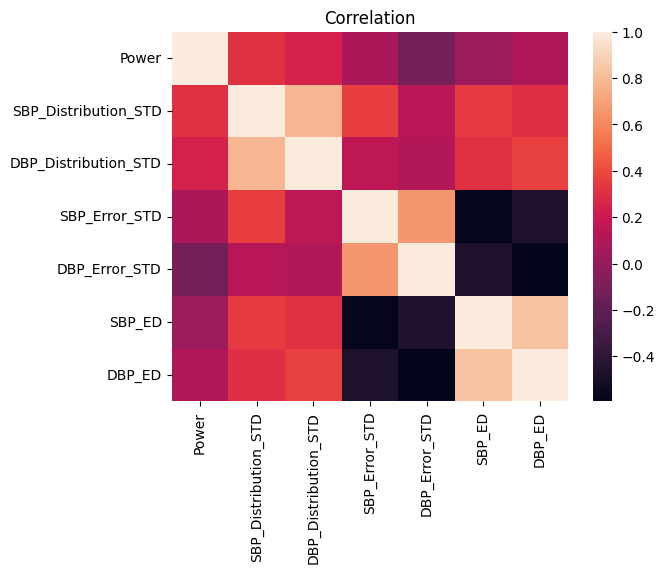

In [37]:
import statsmodels.formula.api as smf
import seaborn as sns

supp_df = df_concat.copy()
supp_df.columns = [x.replace(' ', '_') for x in supp_df.columns.values]
cats = ['Calibration Technique', 'Algorithm', 'Dataset', 'Testing Subject Characteristics', 'Sensor Data']
regs = ['Power', 'SBP Distribution STD', 'DBP Distribution STD', 'SBP Error STD', 'DBP Error STD', 'SBP ED', 'DBP ED']
cats = [x.replace(' ', '_') for x in cats]
regs = [x.replace(' ', '_') for x in regs]

corr = supp_df[regs].corr() 
ax = plt.axes()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
ax.set_title('Correlation')

def regress(reg1, reg2, cats, df):
    
    if cats == None:
        d = df[[reg1, reg2]].dropna()
        model = smf.ols(formula=reg1+'~'+reg2, data=d)
        results = model.fit()
        param = results.params[1]
        pval = results.pvalues[1]
        ci = results.conf_int().values[1, :]
        sig = pval < 0.05
    else:
        cols = [reg1, reg2]
        f = reg1+'~'+reg2
        for cat in cats:
            cols.append(cat)
            f+='+ C('+cat+')'
        if len(cats) == 1:
            cats = cats[0]
        d = df[cols].dropna()
        model = smf.ols(formula=f, data=d)
        results = model.fit()
        param = results.params.values[1:]
        pval = results.pvalues.values[1:]
        ci = results.conf_int().values[1:, :]
        sig = (pval < 0.05).all()
    return results, pd.DataFrame([reg1, reg2, cats, param, pval, ci, sig]).T
   
    

df_search = pd.DataFrame()
plotted_pairs = []
for reg1 in regs:
    for reg2 in regs:
        if (reg1 != reg2) & ((reg2, reg1) not in plotted_pairs):
            plotted_pairs.append((reg1, reg2))
            _, res = regress(reg1, reg2, None, supp_df)
            df_search = pd.concat([df_search, res])
            for cat in cats:
                _, res2 = regress(reg1, reg2, [cat], supp_df)
                df_search = pd.concat([df_search, res2])
df_search.columns = ['Reg1', 'Reg2', 'Cat', 'Slope', 'p-value', 'CI', 'Significant']
df_search.reset_index(drop=True, inplace=True)
df_search.to_csv('supplementary/regression_results.csv', index=False)
df_search[df_search.Significant].to_csv('supplementary/significant_regression_results.csv', index=False)
df_search[df_search.Significant]

In [38]:
res, _ = regress('DBP_ED', 'SBP_ED', ['Testing_Subject_Characteristics'], supp_df)
res.summary()
# between categories not significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DBP_ED   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     39.75
Date:                Wed, 12 Jul 2023   Prob (F-statistic):           1.39e-16
Time:                        18:13:56   Log-Likelihood:                -59.396
No. Observations:                  68   AIC:                             128.8
Df Residuals:                      63   BIC:                             139.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.0357      0.202     -0.177      0.860      -0.439       0.368
C(Testing_Subject_Characteristics)[T.healthy]              0.2144      0.177      1.209      0.231      -0.140       0.569
C(Testing_Subject_Characteristics)[T.healthy+diseased]     0.2952      0.208      1.416      0.162      -0.121       0.712
C(Testing_Subject_Characteristics)[T.unclear]              0.8508      0.328      2.597      0.012       0.196       1.505
SBP_ED                                                     0.7528      0.062     12.187      0.000       0.629       0.876
==============================================================================
Omnibus:                        7.358   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                8.139
Skew:                          -0.486   Prob(JB):                       0.0171
Kurtosis:                       4.389   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plots that make sense:

1. SBP/DBP Distribution STD vs Power
2. SBP Error STD vs DBP Error STD

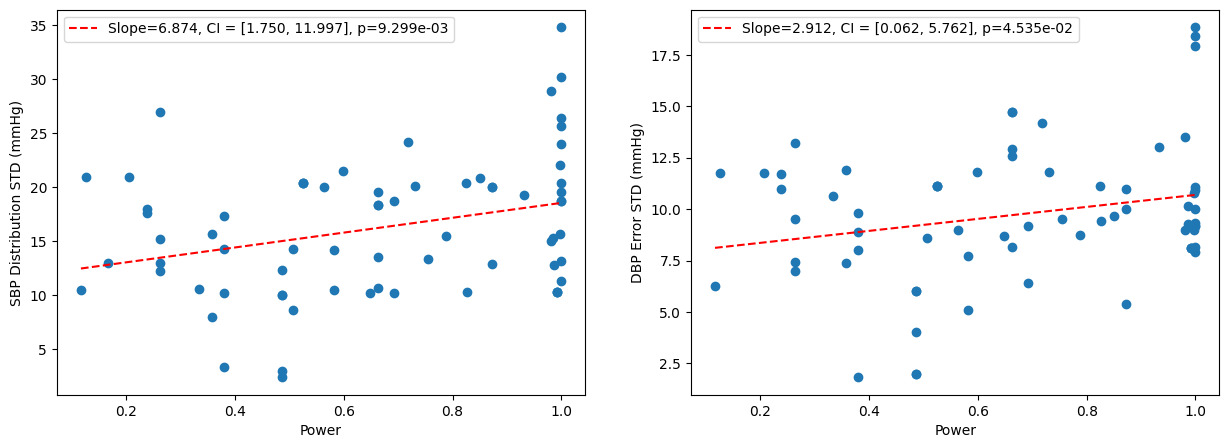

In [39]:
res_s, _ = regress('SBP_Distribution_STD', 'Power', None, supp_df)
res_d, _ = regress('DBP_Distribution_STD', 'Power', None, supp_df)

fig, ax = plt.subplots(1, 2, figsize=(15,5))    
ax[0].scatter(supp_df['Power'], supp_df['SBP_Distribution_STD'])
ax[0].set_xlabel('Power')
ax[0].set_ylabel('SBP Distribution STD (mmHg)')
plot_x = np.linspace(supp_df['Power'].min(), supp_df['Power'].max(), 100)
ax[0].plot(plot_x, res_s.params.values[0] + res_s.params.values[1]*plot_x, linestyle='--', c='r', label='Slope='+"{:.3f}".format(res_s.params.values[1])+', CI = ['+"{:.3f}".format(res_s.conf_int().values[1:, 0][0])+', '+"{:.3f}".format(res_s.conf_int().values[1:, 1][0])+'], p='+"{:.3e}".format(res_s.pvalues.values[1]))
ax[0].legend()
ax[1].scatter(supp_df['Power'], supp_df['DBP_Distribution_STD'])
ax[1].set_xlabel('Power')
ax[1].set_ylabel('DBP Error STD (mmHg)')
ax[1].plot(plot_x, res_d.params.values[0] + res_d.params.values[1]*plot_x, linestyle='--', c='r', label='Slope='+"{:.3f}".format(res_d.params.values[1])+', CI = ['+"{:.3f}".format(res_d.conf_int().values[1:, 0][0])+', '+"{:.3f}".format(res_d.conf_int().values[1:, 1][0])+'], p='+"{:.3e}".format(res_d.pvalues.values[1]))
ax[1].legend()
# res_s.summary(), res_d.summary()

Text(0, 0.5, 'SBP Error STD')

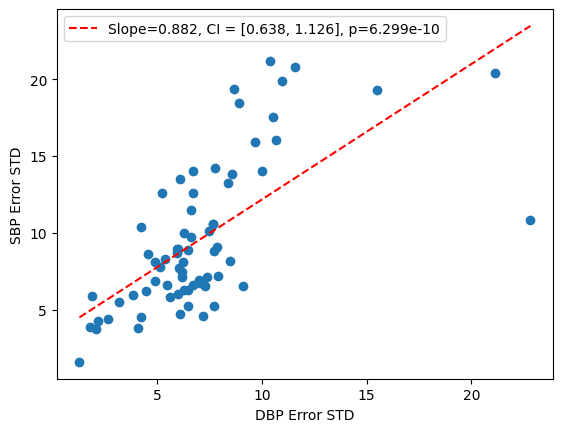

In [40]:
res, _ = regress('SBP_Error_STD', 'DBP_Error_STD', None, supp_df)
plt.scatter(supp_df['DBP_Error_STD'], supp_df['SBP_Error_STD'])
plot_x = np.linspace(supp_df['DBP_Error_STD'].min(), supp_df['DBP_Error_STD'].max(), 100)
plt.plot(plot_x, res.params.values[0] + res.params.values[1]*plot_x, linestyle='--', c='r', label='Slope='+"{:.3f}".format(res.params.values[1])+', CI = ['+"{:.3f}".format(res.conf_int().values[1:, 0][0])+', '+"{:.3f}".format(res.conf_int().values[1:, 1][0])+'], p='+"{:.3e}".format(res.pvalues.values[1]))
plt.legend()
plt.xlabel('DBP Error STD')
plt.ylabel('SBP Error STD')

/var/folders/4k/jr4_f2px17b2sdv74jmvp4x80000gn/T/ipykernel_55722/2158582408.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['seconds','minutes','hours','days','months'])


[Text(-1.0, 0, 'seconds'),
 Text(0.0, 0, 'minutes'),
 Text(1.0, 0, 'hours'),
 Text(2.0, 0, 'days'),
 Text(3.0, 0, 'months'),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, '')]

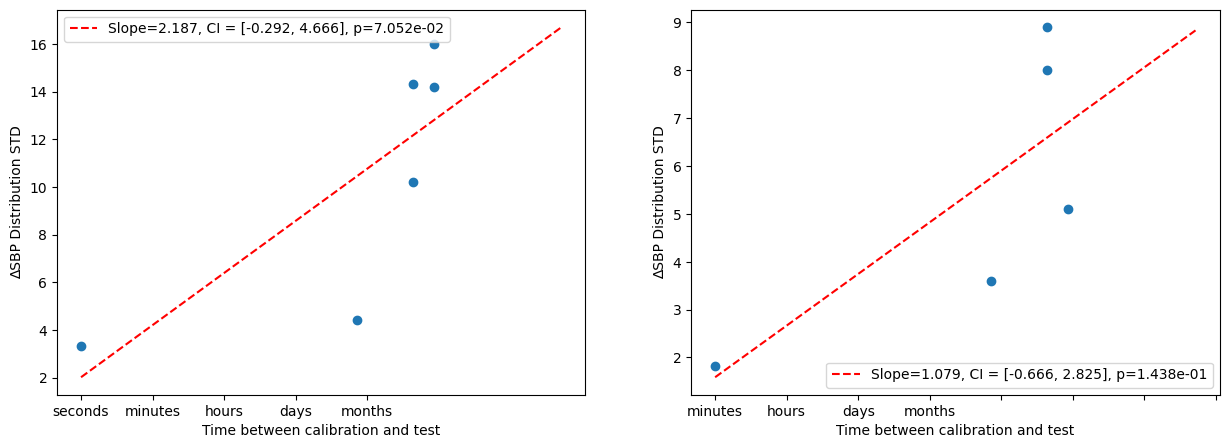

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(per_concat.log_dt, per_concat['SBP Distribution STD'])
ax[1].scatter(per_concat.log_dt, per_concat['DBP Distribution STD'])

temp_df = per_concat.copy()
temp_df.columns = [x.replace(' ', '_') for x in temp_df.columns]
model = smf.ols(formula='SBP_Distribution_STD ~ log_dt', data=temp_df)
res_s = model.fit()
model = smf.ols(formula='DBP_Distribution_STD ~ log_dt', data=temp_df)
res_d = model.fit()

plot_xs = np.linspace(temp_df['log_dt'].min(), temp_df['log_dt'].max(), 100)
plot_xd = np.linspace(temp_df['log_dt'].min(), temp_df['log_dt'].max(), 100)
ax[0].plot(plot_xs, res_s.params.values[0] + res_s.params.values[1]*plot_xs, linestyle='--', c='r', label='Slope='+"{:.3f}".format(res_s.params.values[1])+', CI = ['+"{:.3f}".format(res_s.conf_int().values[1:, 0][0])+', '+"{:.3f}".format(res_s.conf_int().values[1:, 1][0])+'], p='+"{:.3e}".format(res_s.pvalues.values[1]))
ax[1].plot(plot_xs, res_d.params.values[0] + res_d.params.values[1]*plot_xd, linestyle='--', c='r', label='Slope='+"{:.3f}".format(res_d.params.values[1])+', CI = ['+"{:.3f}".format(res_d.conf_int().values[1:, 0][0])+', '+"{:.3f}".format(res_d.conf_int().values[1:, 1][0])+'], p='+"{:.3e}".format(res_d.pvalues.values[1]))
ax[0].legend()
ax[0].set_xticks([0,1,2,3,4])
ax[0].set_ylabel('∆SBP Distribution STD')
ax[0].set_xticklabels(['seconds','minutes','hours','days','months'])
ax[0].set_xlabel('Time between calibration and test')
ax[1].legend()
ax[1].set_ylabel('∆DBP Distribution STD')
ax[1].set_xlabel('Time between calibration and test')
ax[1].set_ylabel('∆SBP Distribution STD')
ax[1].set_xticklabels(['seconds','minutes','hours','days','months'])

In [42]:
for i in df_search.index:
    dsearch = df_search.iloc[i]
    figname = 'supplementary/other_figs/' + dsearch.Reg2+'_'+dsearch.Reg1
    f = dsearch.Reg1+'~'+dsearch.Reg2
    if dsearch.Cat == None:
        plot_df = supp_df[[dsearch.Reg1, dsearch.Reg2]]
        sns.lmplot(data=plot_df, x=dsearch.Reg2, y=dsearch.Reg1, height=5)
    else:
        plot_df = supp_df[[dsearch.Reg1, dsearch.Reg2, dsearch.Cat]]
        f+='C('+dsearch.Cat+')'
        sns.lmplot(data=plot_df, x=dsearch.Reg2, y=dsearch.Reg1, hue=dsearch.Cat, height=5)
        figname+='_'+dsearch.Cat
    ax = plt.gca()
    plt.savefig(figname+'.png')
    plt.close()

In [43]:
dsearch

Reg1                                                      SBP_ED
Reg2                                                      DBP_ED
Cat                                                  Sensor_Data
Slope          [1.246727443712693, 1.0517765165334079, 0.3574...
p-value        [0.07046615839704129, 0.21302567100080513, 0.6...
CI             [[-0.10830003112731057, 2.6017549185526967], [...
Significant                                                False
Name: 125, dtype: object

# Create Benchmark Table

In [44]:
benchmark_data = pd.read_excel('../metadata.xlsx', sheet_name='Benchmarks')
benchmark_key = pd.read_excel('../metadata.xlsx', sheet_name='Benchmark Key')
benchmark_data['ED'] = benchmark_data['SBP ED'].astype(str) + ':' + benchmark_data['DBP ED'].astype(str)

In [45]:
def assign_name(d, key):
    if d == d:
        row = key[key['Benchmark Item Name'] == d]
        return row['Display Name'].values[0]
    else:
        pass

cols = ['Filter', 'Estimator']
for col in cols:
    benchmark_data[col] = benchmark_data[col].apply(assign_name, args=(benchmark_key, ))

In [46]:
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10_3
from bokeh.models import Legend, LegendItem

output_file('./_includes/replicated_ed_scatter.html')

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 10px"> Dataset: @{Dataset} </span> <br>
                <span style="font-size: 10px"> Filter: @{Filter} </span> <br>
                <span style="font-size: 10px"> Estimator: @{Estimator} </span> <br>
                <span style="font-size: 10px"> Reported SBP/DBP ED: @{Reported SBP ED} / @{Reported DBP ED}</span> <br>
                <span style="font-size: 10px"> Replicated SBP/DBP ED: @{SBP ED} / @{DBP ED}</span> <br>
            </div>
        </div>
        """
    )

p21 = figure(title = "Reported vs Replicated ED for SBP and DBP", background_fill_color="#fafafa", plot_width=400, plot_height=400, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p21.xaxis.axis_label = 'Reported SBP ED'
p21.yaxis.axis_label = 'Replicated SBP ED'
p22 = figure(title = "", background_fill_color="#fafafa", plot_width=485, plot_height=400, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p22.xaxis.axis_label = 'Reported DBP ED'
p22.yaxis.axis_label = 'Replicated DBP ED'

cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
shapes = ['circle', 'triangle', 'diamond', 'plus']
dset_unique = benchmark_data['Dataset'].unique()
filter_unique = benchmark_data['Filter'].unique()
color_dict = {}
for i in range(len(dset_unique)):
    color_dict[dset_unique[i]] = cs[i]
shape_dict = {}
for i in range(len(filter_unique)):
    shape_dict[filter_unique[i]] = shapes[i]
benchmark_data['color'] = benchmark_data['Dataset'].apply(lambda x: color_dict[x])
benchmark_data['shape'] = benchmark_data['Filter'].apply(lambda x: shape_dict[x])

legend_it = []
for i in range(len(dset_unique)):
    d = benchmark_data[benchmark_data['Dataset'] == dset_unique[i]]
    c1 = p21.scatter('Reported SBP ED', 'SBP ED', source=ColumnDataSource(d), size=12, color='color', marker='shape')
    c2 = p22.scatter('Reported DBP ED', 'DBP ED', source=ColumnDataSource(d), size=12, color='color', marker='shape')

    legend_it.append((dset_unique[i], [c1, c2]))
legend = Legend(items=legend_it)
legend.click_policy='hide'
p22.add_layout(legend, 'right')
p22.legend.title = 'Dataset'

show(row([p21, p22]))

export_svgs(row([p21, p22]), filename='./_includes/replicated_ed_scatter.svg')

[]

In [47]:
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10_3
from bokeh.models import Legend, LegendItem

output_file('./_includes/replicated_ed_diff_scatter.html')

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <span style="font-size: 10px"> Dataset: @{Dataset} </span> <br>
                <span style="font-size: 10px"> Filter: @{Filter} </span> <br>
                <span style="font-size: 10px"> Estimator: @{Estimator} </span> <br>
                <span style="font-size: 10px"> Reported SBP/DBP ED: @{Reported SBP ED} / @{Reported DBP ED}</span> <br>
                <span style="font-size: 10px"> Replicated SBP/DBP ED: @{SBP ED} / @{DBP ED}</span> <br>
                <span style="font-size: 10px"> SBP/DBP ED Difference: @{SBP ED Difference} / @{DBP ED Difference} </span> <br>
            </div>
        </div>
        """
    )

p1 = figure(title = "Replicated-Reported ED Difference for SBP and DBP", background_fill_color="#fafafa", plot_width=550, plot_height=400, toolbar_location=None, tools=[hover, 'pan', 'wheel_zoom' ,'box_zoom', 'reset'])
p1.xaxis.axis_label = 'Replicated DBP ED - Reported DBP ED'
p1.yaxis.axis_label = 'Replicated SBP ED - Reported SBP ED'

cs = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
shapes = ['circle', 'triangle', 'diamond', 'plus']
dset_unique = benchmark_data['Dataset'].unique()
filter_unique = benchmark_data['Filter'].unique()
color_dict = {}
for i in range(len(dset_unique)):
    color_dict[dset_unique[i]] = cs[i]
shape_dict = {}
for i in range(len(filter_unique)):
    shape_dict[filter_unique[i]] = shapes[i]
benchmark_data['color'] = benchmark_data['Dataset'].apply(lambda x: color_dict[x])
benchmark_data['shape'] = benchmark_data['Filter'].apply(lambda x: shape_dict[x])
benchmark_data['SBP ED Difference'] = benchmark_data['SBP ED'].astype(float) - benchmark_data['Reported SBP ED'].astype(float)
benchmark_data['DBP ED Difference'] = benchmark_data['DBP ED'].astype(float) - benchmark_data['Reported DBP ED'].astype(float)

legend_it = []
for i in range(len(dset_unique)):
    d = benchmark_data[benchmark_data['Dataset'] == dset_unique[i]]
    c1 = p1.scatter('DBP ED Difference', 'SBP ED Difference', source=ColumnDataSource(d), size=12, color='color', marker='shape')
    legend_it.append((dset_unique[i], [c1]))
legend = Legend(items=legend_it)
legend.click_policy='hide'
p1.add_layout(legend, 'right')
p1.legend.title = 'Dataset'

show(p1)

export_svgs(p1, filename='./_includes/replicated_ed_diff_scatter.svg')

[]

In [48]:
d = benchmark_data.copy().dropna(how='all')
def assign_url(d, key):
    if d == d:
        row = key[key['Display Name'] == d]
        return '<a href="' + row['URL'].values[0] + '">' + row['Display Name'].values[0] + '</a>'
    else:
        pass

cols = ['Filter', 'Estimator']
for col in cols:
    d[col] = d[col].apply(assign_url, args=(benchmark_key, ))

d = d.pivot(index=['Dataset', 'Filter'], columns='Estimator', values='ED').T

In [49]:
d.reset_index().to_html('./_includes/benchmark_table.html', index=False, render_links=True, table_id='btable', escape=False)

# Create Dataset Table

In [50]:
data = pd.read_excel('../metadata.xlsx', sheet_name='Publicly Available Datasets')

In [51]:
data['Dataset Name'] = make_clickable(data['Dataset Name'], data['Dataset URL'])
data['Article URL'] = make_clickable('Article URL', data['Dataset URL'])

In [52]:
data[['Dataset Name', 'Article URL', 'Sensor Data', 'Number of Subjects', 'Study Characteristics', 'BP Distribution SBP', 'BP Distribution DBP', 'Access', 'Notes']].to_html('./_includes/dataset_table.html', index=False, render_links=True, table_id='dtable', escape=False)

# Remove Doctype formatting

In [53]:
import os
for fname in os.listdir('./_includes'):
    if (('scatter' in fname) | ('_stats' in fname)) & ('.html' in fname):
        fpath = './_includes/' + fname
        with open(fpath, 'rb') as fin:
            data = fin.read().splitlines(True)
        with open(fpath, 'wb') as fout:
            fout.writelines(data[1:])